# Analysis of a network model mimicking rural street networks

In [5]:
#Load Libraries

import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import csv
import collections
from scipy.spatial import Delaunay

In [3]:
#Generate village centers
def genRandCirc(n,radius):
    sr=np.random.uniform(0,1,size=n)
    r=np.sqrt(sr*radius)
    theta=np.random.uniform(0,1,size=n)*2*np.pi
    y=r*np.cos(theta)
    x=r*np.sin(theta)
    return [x,y]   

In [4]:
def genRandRural(n, radius, listx, listy):
    numcenter = len(listx)
    xveclist = []
    yveclist = []

    # Iterate through each center to generate random nodes around them.
    for counter in range(0, numcenter):
        [xlistr, ylistr] = genRandCirc(n, radius)  # Generate random nodes in a circular pattern.
        xveclist.append(listx[counter] + xlistr)  
        yveclist.append(listy[counter] + ylistr)

    xveclista = np.asarray(xveclist)
    yveclista = np.asarray(yveclist)

    return [xveclista.flatten(), yveclista.flatten()]  # Return the flattened numpy arrays of x and y coordinates.


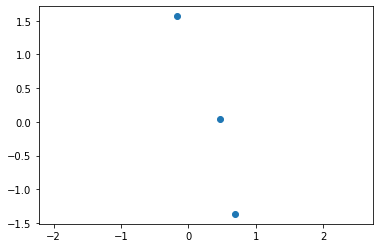

In [7]:
#generate village centers
numvilagecenters=3
[xvec,yvec]=genRandCirc(numvilagecenters,numvilagecenters)
plt.scatter(xvec,yvec)
plt.axis('equal')
plt.show()

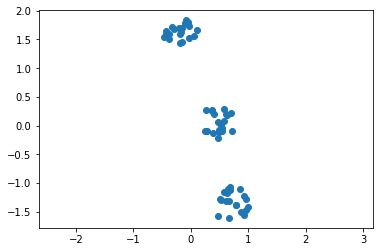

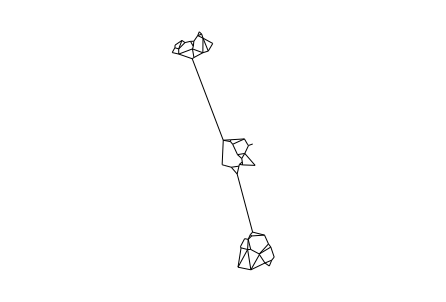

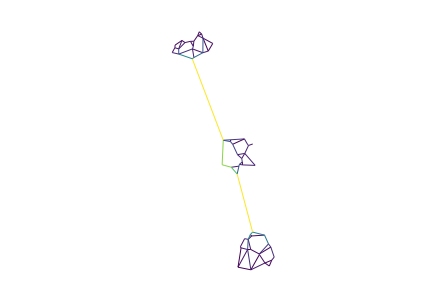

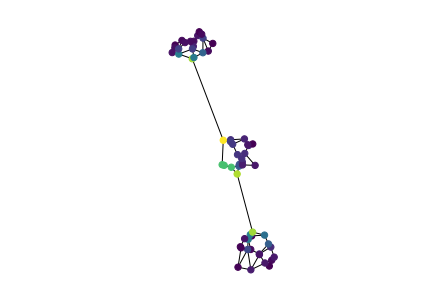

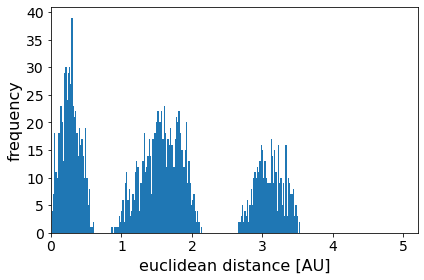

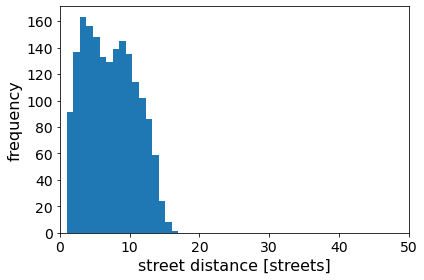

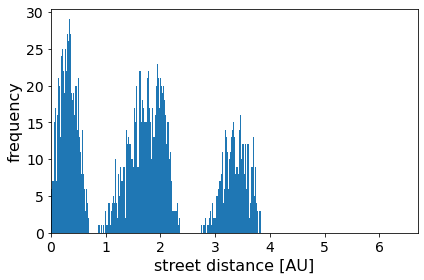

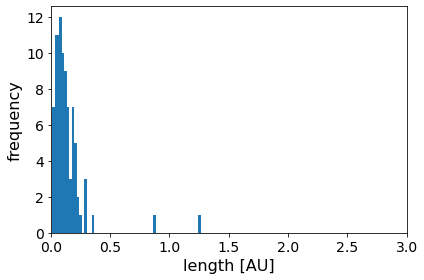

In [8]:
numCC=numvilagecenters

#create rural spots
ruralspots=20
ruralradius=0.1

#generate random rural centers
[xvec2,yvec2]=genRandRural(ruralspots,ruralradius,xvec,yvec)

#plot and check
plt.scatter(xvec2,yvec2)
plt.axis('equal')
plt.show()

#make Delaunay triangulation
posvec=np.asarray([xvec2,yvec2])
posvect=posvec.transpose()
vertices=Delaunay(posvect)


#create edge list
edges=set()
for n in range(vertices.nsimplex):
    edge=sorted([vertices.vertices[n,0],vertices.vertices[n,1]])
    edges.add((edge[0],edge[1]))
    edge=sorted([vertices.vertices[n,0],vertices.vertices[n,2]])
    edges.add((edge[0],edge[1]))
    edge=sorted([vertices.vertices[n,1],vertices.vertices[n,2]])
    edges.add((edge[0],edge[1]))

#make a graph
Grural = nx.Graph()
Grural.add_nodes_from(range(len(posvect)))
Grural.add_edges_from(edges)
for counter in range(len(posvect)):
    Grural.nodes[counter]['pos']=[posvect[counter,0],posvect[counter,1]]
    


#create Gabriel graph
listofnextneighbours=[]
startpoint=0

A = nx.adjacency_matrix(Grural)  #adjacency matrix
Ac=A.toarray()
Anew=np.zeros((len(posvect),len(posvect)))
A2=A*A
A2c=A2.toarray()
indices=np.where(Ac[startpoint,:]>0)


#delete edges for Gabriel graph
for counter in range(len(posvect)):
    indicesy=np.where(Ac[counter,:]>0)
    indexlisty=indicesy[0].tolist()
    indexx=counter
    for countery in range(len(indexlisty)):
        indexy=indexlisty[countery]
        if (indexx!=indexy):
            indicesx=np.where(Ac[indexy,:]>0)
            indexlistx=indicesx[0].tolist()
            fullindexlist=indexlisty+indexlistx
            #print(fullindexlist)
            midpointx=(posvect[indexx,0]+posvect[indexy,0])/2
            midpointy=(posvect[indexx,1]+posvect[indexy,1])/2
            distance=np.sqrt((posvect[indexx,0]-posvect[indexy,0])**2+(posvect[indexx,1]-posvect[indexy,1])**2)/2
            edgeremains=True
            for countern in range(len(fullindexlist)):
                indexn=fullindexlist[countern]
                if (indexn!=indexx) and (indexn!=indexy):
                    newdistance=np.sqrt((midpointx-posvect[indexn,0])**2+(midpointy-posvect[indexn,1])**2)
                    #print([indexx,indexy,indexn,distance,newdistance])
                    if newdistance<distance:
                        edgeremains=False
            if edgeremains:
                Anew[indexx,indexy]=1

#create Gabriel graph in networkX
rows, cols = np.where(Anew == 1)
edges2 = zip(rows.tolist(), cols.tolist())

Grural2 = nx.Graph()
Grural2.add_nodes_from(range(len(posvect)))
Grural2.add_edges_from(edges2)
for counter in range(len(posvect)):
    Grural2.nodes[counter]['pos']=[posvect[counter,0],posvect[counter,1]]

    
#draw Gabriel graph and check    
nx.draw(Grural2, nx.get_node_attributes(Grural2, 'pos'), with_labels=False, node_size=0)
plt.axis('equal')
filename='Figures1/CC-'+str(numCC)+'_CS-'+str(ruralspots)+'_RR-'+str(ruralradius)+'_GabGraph.pdf'
#plt.tight_layout()
plt.savefig(filename)
plt.show()

#create copy of Gabriel graph for edge betweenness centrality
edges3=nx.edge_betweenness_centrality(Grural2)
nodes3=nx.betweenness_centrality(Grural2)

#print(edges3)

Grural3 = nx.Graph()
Grural3.add_nodes_from(range(len(posvect)))
Grural3.add_edges_from(edges3)
for counter in range(len(posvect)):
    Grural3.nodes[counter]['pos']=[posvect[counter,0],posvect[counter,1]]
    
nx.set_edge_attributes(Grural3, edges3, "betweenness")
nx.set_node_attributes(Grural3, nodes3, "betweenness")


#create and plot graph with edge color
edges,weights = zip(*nx.get_edge_attributes(Grural3,'betweenness').items())
nx.draw(Grural3, nx.get_node_attributes(Grural3, 'pos'), with_labels=False, node_size=0,edgelist=edges, edge_color=weights)
plt.axis('equal')
filename='Figures1/CC-'+str(numCC)+'_CS-'+str(ruralspots)+'_RR-'+str(ruralradius)+'_GraphEdgeBetween.pdf'
#plt.tight_layout()
plt.savefig(filename)
plt.show()

#create and plot graph with node color
nodes,weights = zip(*nx.get_node_attributes(Grural3,'betweenness').items())
nx.draw(Grural3, nx.get_node_attributes(Grural3, 'pos'), with_labels=False, node_size=40,nodelist=nodes, node_color=weights)
plt.axis('equal')
filename='Figures1/CC-'+str(numCC)+'_CS-'+str(ruralspots)+'_RR-'+str(ruralradius)+'_GraphNodeBetween.pdf'
#plt.tight_layout()
plt.savefig(filename)
plt.show()

#Generate euclidean distance between junctions
totaldistanceED=[]
for u in range(len(posvect)):
    for v in range(len(posvect)):
        if u<v:
            newdistance=np.sqrt((posvect[u,0]-posvect[v,0])**2+(posvect[u,1]-posvect[v,1])**2)
            totaldistanceED.append(newdistance)

#plot histogram            
plt.hist(totaldistanceED,200)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('euclidean distance [AU]',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,5.2)
filename='Figures1/CC-'+str(numCC)+'_CS-'+str(ruralspots)+'_RR-'+str(ruralradius)+'_DistanceEuc.pdf'
plt.tight_layout()
plt.savefig(filename)
plt.show()

#Generate edge distance between junctions
totaldistanceEDD=[]
lendistance=dict(nx.all_pairs_shortest_path_length(Grural3))
for u in range(len(posvect)):
    for v in range(len(posvect)):
        if u<v:
            newdistance=lendistance[u][v]
            totaldistanceEDD.append(newdistance)
            
#plot histogram            
plt.hist(totaldistanceEDD,np.max(totaldistanceEDD))
plt.ylabel('frequency',fontsize=16)
plt.xlabel('street distance [streets]',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,50)
filename='Figures1/CC-'+str(numCC)+'_CS-'+str(ruralspots)+'_RR-'+str(ruralradius)+'_DistanceStreets.pdf'
plt.tight_layout()
plt.savefig(filename)
plt.show()


#Generate weigthed edge distance between junctions
collectalllengths=[]
for u,v in Grural3.edges(data=False):
    Grural3.edges[u,v]['length'] = np.sqrt((posvect[u,0]-posvect[v,0])**2+(posvect[u,1]-posvect[v,1])**2)
    collectalllengths.append(np.sqrt((posvect[u,0]-posvect[v,0])**2+(posvect[u,1]-posvect[v,1])**2))
    
    
totaldistanceWED=[]
lendistance=dict(nx.all_pairs_dijkstra_path_length(Grural3, cutoff=None, weight='length'))
for u in range(len(posvect)):
    for v in range(len(posvect)):
        if u<v:
            newdistance=lendistance[u][v]
            totaldistanceWED.append(newdistance)
            

#plot histogram
plt.hist(totaldistanceWED,200)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('street distance [AU]',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,6.7)
filename='Figures1/CC-'+str(numCC)+'_CS-'+str(ruralspots)+'_RR-'+str(ruralradius)+'_DistanceStreetsWeight.pdf'
plt.tight_layout()
plt.savefig(filename)
plt.show()

plt.hist(collectalllengths,60)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('length [AU]',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,3)
filename='Figures1/CC-'+str(numCC)+'_CS-'+str(ruralspots)+'_RR-'+str(ruralradius)+'_LengthStreets.pdf'
plt.tight_layout()
plt.savefig(filename)
plt.show()



0.07830756813807661
0.08337989693921898


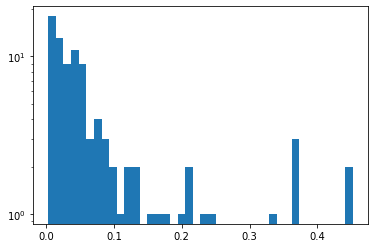

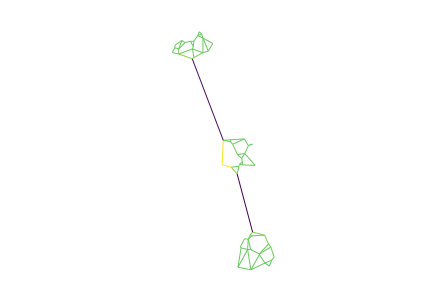

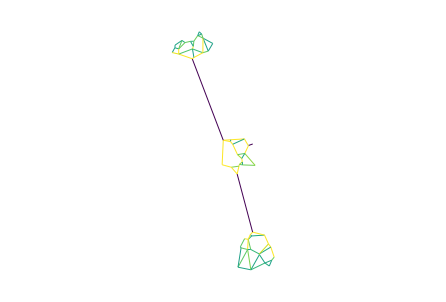

In [12]:
#compute the weighted betweenness centrality
edges4=nx.edge_betweenness_centrality(Grural3,weight='length')
nodes4=nx.betweenness_centrality(Grural3,weight='length')
nx.set_edge_attributes(Grural3, edges4, "betweenness2")
nx.set_node_attributes(Grural3, nodes4, "betweenness2")
#print(Grural3.edges[0,7]['length'])
#print(Grural3.edges(data=True))


#compute average betweenness centrality
averageBetweeness=[]
for u,v in Grural3.edges(data=False):
    averageBetweeness.append(Grural3.edges[u,v]['betweenness'])
meanaverage=np.mean(averageBetweeness)
print(meanaverage)

averageBetweeness2=[]
for u,v in Grural3.edges(data=False):
    averageBetweeness2.append(Grural3.edges[u,v]['betweenness2'])
meanaverage2=np.mean(averageBetweeness2)
print(meanaverage2)

#compute impact (unweighted)
GruralDel = nx.Graph()
GruralDel.add_nodes_from(range(len(posvect)))
GruralDel.add_edges_from(Grural3.edges(data=True))
for counter in range(len(posvect)):
    GruralDel.nodes[counter]['pos']=[posvect[counter,0],posvect[counter,1]]
counter=0
for u,v in Grural3.edges(data=False):
    counter=counter+1
    #print(counter/len(averageBetweeness))
    savelen=Grural3.edges[u,v]['length']
    GruralDel.remove_edge(u, v)
    edgesDel=nx.edge_betweenness_centrality(GruralDel)
    nx.set_edge_attributes(GruralDel, edgesDel, "betweennessDEL")
    averageBetweenessDel=[]
    for x,y in GruralDel.edges(data=False):
        averageBetweenessDel.append(GruralDel.edges[x,y]['betweennessDEL'])

    meanaverageDel=np.mean(averageBetweenessDel)
    #print([u,v,(meanaverageDel-meanaverage)/meanaverage])
    Grural3.edges[u,v]['del'] = ((meanaverageDel-meanaverage)/meanaverage)
    GruralDel.add_edge(u, v,length=savelen)

#compute impact (unweighted)    
GruralDel = nx.Graph()
GruralDel.add_nodes_from(range(len(posvect)))
GruralDel.add_edges_from(Grural3.edges(data=True))
for counter in range(len(posvect)):
    GruralDel.nodes[counter]['pos']=[posvect[counter,0],posvect[counter,1]]
    
counter=0 
for u,v in Grural3.edges(data=False):
    counter=counter+1
    #print(counter/len(averageBetweeness))
    savelen=Grural3.edges[u,v]['length']
    GruralDel.remove_edge(u, v)
    edgesDel=nx.edge_betweenness_centrality(GruralDel,weight='length')
    nx.set_edge_attributes(GruralDel, edgesDel, "betweennessDEL")
    averageBetweenessDel=[]
    for x,y in GruralDel.edges(data=False):
        averageBetweenessDel.append(GruralDel.edges[x,y]['betweennessDEL'])

    meanaverageDel=np.mean(averageBetweenessDel)
    #print([u,v,(meanaverageDel-meanaverage)/meanaverage])
    Grural3.edges[u,v]['delW'] = ((meanaverageDel-meanaverage2)/meanaverage2)
    GruralDel.add_edge(u, v,length=savelen)

    
plt.hist(averageBetweeness,40)
plt.yscale('log')
#plt.xscale('log')
plt.show()

edges,weights = zip(*nx.get_edge_attributes(Grural3,'del').items())

nx.draw(Grural3, nx.get_node_attributes(Grural3, 'pos'), with_labels=False, node_size=0,edgelist=edges, edge_color=weights)
plt.axis('equal')
plt.show()


edges,weights = zip(*nx.get_edge_attributes(Grural3,'del').items())

nx.draw(Grural3, nx.get_node_attributes(Grural3, 'pos'), with_labels=False, node_size=0,edgelist=edges, edge_color=weights,edge_vmin=-0.0,edge_vmax=0.02)
plt.axis('equal')
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


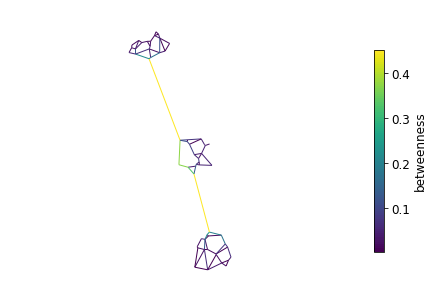

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


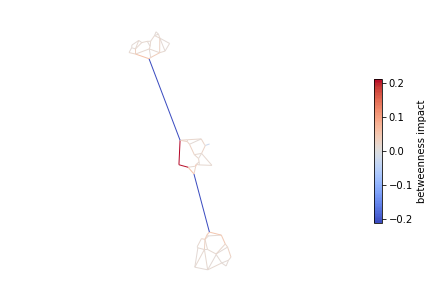

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


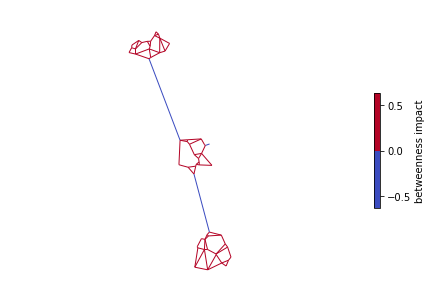

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


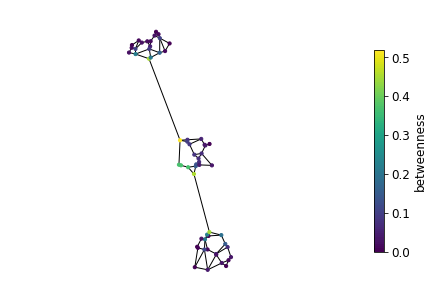

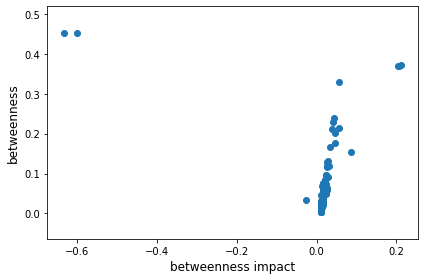

In [11]:
nodes3=nx.closeness_centrality(Grural3)

#print(edges3)


nx.set_node_attributes(Grural3, nodes3, "closeness")

seismic = plt.cm.get_cmap('coolwarm', 100)
viridis = plt.cm.get_cmap('viridis', 100)

#create and plot graph with edge color

edges,weights = zip(*nx.get_edge_attributes(Grural3,'betweenness').items())

vmin = min(weights)
vmax = max(weights)

nx.draw(Grural3, nx.get_node_attributes(Grural3, 'pos'), with_labels=False, node_size=0,edgelist=edges, edge_color=weights,edge_vmin=vmin, edge_vmax=vmax,edge_cmap=viridis)

sm = plt.cm.ScalarMappable(cmap=viridis, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cbar=plt.colorbar(sm,shrink=0.7)
cbar.ax.tick_params(labelsize=12) 
cbar.ax.set_ylabel('betweenness',fontsize=12)

plt.tight_layout()
plt.axis('equal')

filename='Figures1/CC-'+str(numCC)+'_CS-'+str(ruralspots)+'_RR-'+str(ruralradius)+'_Betweenness.pdf'
plt.savefig(filename)

plt.show()

###########

#create and plot graph with edge color

edges,weights = zip(*nx.get_edge_attributes(Grural3,'del').items())

#delprop=[]
#for u,v in GBawue2.edges(data=False):
#    delprop.append(GBawue2.edges[u,v]['del'])

vmin = -max(weights)
vmax = max(weights)

#nx.draw(GBawue2, nx.get_node_attributes(GBawue2, 'pos'), with_labels=False, node_size=0,edgelist=edges, edge_color=weights,edge_cmap=seismic,edge_vmin=min(delprop),edge_vmax=-min(delprop))
nx.draw(Grural3, nx.get_node_attributes(Grural3, 'pos'), with_labels=False, node_size=0,edgelist=edges, edge_color=weights,edge_vmin=vmin, edge_vmax=vmax,edge_cmap=seismic)

sm = plt.cm.ScalarMappable(cmap=seismic, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cbar=plt.colorbar(sm,shrink=0.5)
cbar.ax.tick_params(labelsize=10) 
cbar.ax.set_ylabel('betweenness impact',fontsize=10)

plt.tight_layout()
plt.axis('equal')

filename='Figures1/CC-'+str(numCC)+'_CS-'+str(ruralspots)+'_RR-'+str(ruralradius)+'_BetweennessImpact.pdf'
plt.savefig(filename)

plt.show()

###########




for u,v in Grural3.edges(data=False):
    if Grural3.edges[u,v]['del']<0:
        Grural3.edges[u,v]['del2'] = min(weights)
    elif Grural3.edges[u,v]['del']>0:
        Grural3.edges[u,v]['del2'] = -min(weights)
    else:
        Grural3.edges[u,v]['del2'] = 0
        

#create and plot graph with edge color

edges,weights = zip(*nx.get_edge_attributes(Grural3,'del2').items())
seismic2 = plt.cm.get_cmap('coolwarm', 2)

#delprop=[]
#for u,v in GBawue2.edges(data=False):
#    delprop.append(GBawue2.edges[u,v]['del'])

vmin = min(weights)
vmax = -min(weights)

#nx.draw(GBawue2, nx.get_node_attributes(GBawue2, 'pos'), with_labels=False, node_size=0,edgelist=edges, edge_color=weights,edge_cmap=seismic,edge_vmin=min(delprop),edge_vmax=-min(delprop))
nx.draw(Grural3, nx.get_node_attributes(Grural3, 'pos'), with_labels=False, node_size=0,edgelist=edges, edge_color=weights,edge_vmin=vmin, edge_vmax=vmax,edge_cmap=seismic2)

sm = plt.cm.ScalarMappable(cmap=seismic2, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cbar=plt.colorbar(sm,shrink=0.4)
cbar.ax.tick_params(labelsize=10) 
cbar.ax.set_ylabel('betweenness impact',fontsize=10)

plt.tight_layout()
plt.axis('equal')

filename='Figures1/CC-'+str(numCC)+'_CS-'+str(ruralspots)+'_RR-'+str(ruralradius)+'_BetweennessImpact2.pdf'
plt.savefig(filename)

plt.show()

###########


#create and plot graph with edge color

nodes,weights = zip(*nx.get_node_attributes(Grural3,'betweenness').items())

vmin = min(weights)
vmax = max(weights)

nx.draw(Grural3, nx.get_node_attributes(Grural3, 'pos'), with_labels=False, node_size=10,nodelist=nodes, node_color=weights,vmin=vmin, vmax=vmax,cmap=viridis)

sm = plt.cm.ScalarMappable(cmap=viridis, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cbar=plt.colorbar(sm,shrink=0.7)
cbar.ax.tick_params(labelsize=12) 
cbar.ax.set_ylabel('betweenness',fontsize=12)

plt.tight_layout()
plt.axis('equal')

filename='Figures1/CC-'+str(numCC)+'_CS-'+str(ruralspots)+'_RR-'+str(ruralradius)+'_BetweennessNode.pdf'
plt.savefig(filename)

plt.show()

###########


#scatter plot

delprop2=[]
for u,v in Grural3.edges(data=False):
    delprop2.append([Grural3.edges[u,v]['del'],Grural3.edges[u,v]['betweenness']])
delprop2a=np.asarray(delprop2)

plt.scatter(delprop2a[:,0],delprop2a[:,1])
plt.xlabel('betweenness impact',fontsize=12)
plt.ylabel('betweenness',fontsize=12)

plt.tight_layout()
plt.axis('equal')

filename='Figures1/CC-'+str(numCC)+'_CS-'+str(ruralspots)+'_RR-'+str(ruralradius)+'_ScatterBetween.pdf'
plt.savefig(filename)
plt.show()
